In [149]:
from __future__ import division


# Library Packages
import regex as re
import itertools as it
import spacy
import numpy as np
import pandas as pd


# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
seed = 7
np.random.seed(seed)

import warnings

warnings.filterwarnings('ignore')


def front(self, n):
    return self.iloc[:, :n]


def back(self, n):
    return self.iloc[:, -n:]

from sklearn.preprocessing import StandardScaler
np.set_printoptions(threshold=np.nan)

from datetime import datetime
from dateutil.parser import parse
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import re
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.preprocessing import MinMaxScaler

# Entity Extraction From Review
import itertools as it
import spacy


def Standardisation(df):
    listed = list(df)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    df = pd.DataFrame(scaled)
    df.columns = listed
    return df



# Like normalization, standardization can be useful, and even required in some
# machine learning algorithms when your time series data has input values with differing scales.


companies = ["bjs_gd"]

for p in companies:


    glassdoor = pd.read_csv(p +".csv")

    # This is just the glassdoor processing step.


    glassdoor['Review Date'] = glassdoor['Review Date'].apply(lambda x: parse(x))

    # Good
    # Bad
    # Great
    # Severe

    glassdoor["Pros"] = glassdoor["Pros"].apply(lambda x: re.sub('<br\s*?>', '. ', x))
    glassdoor["Cons"] = glassdoor["Cons"].apply(lambda x: re.sub('<br\s*?>', '. ', x))
    glassdoor["Advice to Management"] = glassdoor["Advice to Management"].fillna(value="").apply(
        lambda x: re.sub('<br\s*?>', '. ', x))

    glassdoor["Location"] = glassdoor["Location"].fillna(value="np.nan, np.nan")

    glassdoor["Location"] = glassdoor["Location"].apply(lambda x: x.split(",")[0])


glassdoor = glassdoor.sort_values("Review Date", ascending=True)

glassdoor["roll25"] = pd.rolling_mean(glassdoor["Rating"],25)
glassdoor["roll100"] = pd.rolling_mean(glassdoor["Rating"],100)
glassdoor["roll250"] = pd.rolling_mean(glassdoor["Rating"],250)

glassdoor["roll100"] = glassdoor["roll100"].fillna(glassdoor["roll25"])
glassdoor["roll250"] = glassdoor["roll250"].fillna(glassdoor["roll100"])
glassdoor["roll250"] = glassdoor["roll250"].fillna(glassdoor["roll25"])

glassdoor = glassdoor.sort_values("Review Date", ascending=False)

glassdoor["special_25"] = pd.rolling_mean(glassdoor["Rating"],25)

glassdoor["special_25"] = glassdoor["special_25"]*.80 + glassdoor["Rating"]*.10
# Left 10% out here, that is okay I assume. 

glassdoor["roll100"] = glassdoor["roll100"].fillna(glassdoor["special_25"])
glassdoor["roll25"] = glassdoor["roll25"].fillna(glassdoor["special_25"])
glassdoor["roll250"] = glassdoor["roll250"].fillna(glassdoor["special_25"])

glassdoor = glassdoor.sort_values("Review Date", ascending=True)

glassdoor["final_rating"] = glassdoor["roll25"]*.60 + glassdoor["roll100"] *.30 + glassdoor["roll100"] *.10

tick = "BJRI"
year = int(2008)

from pandas_datareader.google.daily import GoogleDailyReader
from datetime import datetime, timedelta


class FixedGoogleDailyReader(GoogleDailyReader):
    @property
    def url(self):
        return 'http://finance.google.com/finance/historical'


start = datetime(year, 1, 1)
end = datetime.now()
df_tick = pd.DataFrame(
    FixedGoogleDailyReader(tick, start=start, end=end, chunksize=25, retry_count=3, pause=0.001, session=None).read())
df_tick = df_tick.reset_index()
df_tick = df_tick.rename(
    columns={'Volume': 'volume', 'Close': 'close', 'High': 'high', 'Low': 'low', 'Open': 'open', 'Date': 'date'})

# bench = "MENU"

# df_bench = pd.DataFrame(FixedGoogleDailyReader(bench, start=start, end=end, chunksize=25, retry_count=3, pause=0.001, session=None).read())
# df_bench = df_bench.reset_index()
# df_bench = df_bench.rename(columns={'Volume':'volume','Close':'close', 'High':'high', 'Low':'low', 'Open':'open', 'Date':'date'})



multiplier = df_tick["close"].tail(1).values[0]/glassdoor["final_rating"].tail(1).values[0]

glassdoor["final_rating"] = glassdoor["final_rating"] * multiplier


yelp = pd.read_csv("bjs-restaurant-sanbruno.csv")

yelp["date"] = yelp["date"].apply(lambda x: x[:10])
yelp["date"] = yelp["date"].apply(lambda x: x[:-1] if x[-1]=="\\" else x )
yelp["date"] = yelp["date"].apply(lambda x: x[:-2] if x[-1]=="n" else x )

from datetime import datetime
from dateutil.parser import parse

yelp['date'] = yelp['date'].apply(lambda x: parse(x))



yelp = yelp.sort_values("date", ascending=True)

yelp["roll25"] = pd.rolling_mean(yelp["rating"],25)
yelp["roll100"] = pd.rolling_mean(yelp["rating"],100)
yelp["roll250"] = pd.rolling_mean(yelp["rating"],250)

yelp["roll100"] = yelp["roll100"].fillna(yelp["roll25"])
yelp["roll250"] = yelp["roll250"].fillna(yelp["roll100"])
yelp["roll250"] = yelp["roll250"].fillna(yelp["roll25"])

yelp = yelp.sort_values("date", ascending=False)

yelp["special_25"] = pd.rolling_mean(yelp["rating"],25)

yelp["special_25"] = yelp["special_25"]*.80 + yelp["rating"]*.10
# Left 10% out here, that is okay I assume. 

yelp["roll100"] = yelp["roll100"].fillna(yelp["special_25"])
yelp["roll25"] = yelp["roll25"].fillna(yelp["special_25"])
yelp["roll250"] = yelp["roll250"].fillna(yelp["special_25"])

yelp = yelp.sort_values("date", ascending=True)

yelp["final_rating"] = yelp["roll25"]*.40 + yelp["roll100"] *.40 + yelp["roll100"] *.20

multiplier = df_tick["close"].tail(1).values[0]/yelp["final_rating"].tail(1).values[0]

yelp["final_rating"] = yelp["final_rating"] * multiplier

glassdoor = glassdoor[glassdoor["Review Date"]>"2012-01-01"]
df_tick = df_tick[df_tick["date"]>"2012-01-01"]
yelp = yelp[yelp["date"]>"2012-01-01"]

glassdoor["manager"] = glassdoor["Employee Title"].apply(lambda x:1 if "Manager" in str(x) else 0)

glassdoor_m = glassdoor[glassdoor["manager"]==1]

glassdoor_m = glassdoor_m.sort_values("Review Date", ascending=True)

glassdoor_m["roll25"] = pd.rolling_mean(glassdoor_m["Rating"],5)
glassdoor_m["roll100"] = pd.rolling_mean(glassdoor_m["Rating"],10)
glassdoor_m["roll250"] = pd.rolling_mean(glassdoor_m["Rating"],15)

glassdoor_m["roll100"] = glassdoor_m["roll100"].fillna(glassdoor_m["roll25"])
glassdoor_m["roll250"] = glassdoor_m["roll250"].fillna(glassdoor_m["roll100"])
glassdoor_m["roll250"] = glassdoor_m["roll250"].fillna(glassdoor_m["roll25"])

glassdoor_m = glassdoor_m.sort_values("Review Date", ascending=False)

glassdoor_m["special_25"] = pd.rolling_mean(glassdoor_m["Rating"],25)

glassdoor_m["special_25"] = glassdoor_m["special_25"]*.80 + glassdoor_m["Rating"]*.10
# Left 10% out here, that is okay I assume. 

glassdoor_m["roll100"] = glassdoor_m["roll100"].fillna(glassdoor_m["special_25"])
glassdoor_m["roll25"] = glassdoor_m["roll25"].fillna(glassdoor_m["special_25"])
glassdoor_m["roll250"] = glassdoor_m["roll250"].fillna(glassdoor_m["special_25"])

glassdoor_m = glassdoor_m.sort_values("Review Date", ascending=True)

glassdoor_m["final_rating"] = glassdoor_m["roll25"]*.60 + glassdoor_m["roll100"] *.30 + glassdoor_m["roll100"] *.10

multiplier = df_tick["close"].tail(1).values[0]/glassdoor_m["final_rating"].tail(1).values[0]

glassdoor_m["final_rating"] = glassdoor_m["final_rating"] * multiplier

glassdoor = glassdoor[glassdoor["Review Date"]>"2012-01-01"]
glassdoor_m = glassdoor_m[glassdoor_m["Review Date"]>"2012-01-01"]

df_tick = df_tick[df_tick["date"]>"2012-01-01"]
yelp = yelp[yelp["date"]>"2012-01-01"]

glassdoor.to_csv("gdoor_employee_rate.csv")
glassdoor_m.to_csv("gdoor_mgmt_rate.csv")
df_tick.to_csv("stock_rate.csv")
yelp.to_csv("cutomer_rate")


In [150]:

trace_high = go.Scatter(
    x=glassdoor["Review Date"],
    y=glassdoor["final_rating"],
    name = "Employees",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

trace_green = go.Scatter(
    x=glassdoor_m["Review Date"],
    y=glassdoor_m["final_rating"],
    name = "Managers",
    line = dict(color = 'green'),
    opacity = 0.8)


trace_low = go.Scatter(
    x=df_tick["date"],
    y=df_tick["close"],
    name = "Stock",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

trace_three = go.Scatter(
    x=yelp["date"],
    y=yelp["final_rating"],
    name = "Customers",
    line = dict(color = "orange"),
    opacity = 0.8)


data = [trace_high,trace_green,trace_low,trace_three]

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Time Series with Rangeslider")

In [ ]:
def sent(type_t, glassdoor):
        glassdoor["positive"] = 0
        glassdoor["compound"] = 0.0
        glassdoor["negative"] = 0
        glassdoor["neutral"] = 0

        analyzer = SIA()
        for sentence, row in zip(glassdoor[type_t], list(range(glassdoor.shape[0]))):
            vs = analyzer.polarity_scores(sentence)
            glassdoor["compound"][row] = float(vs["compound"])
            if vs["compound"] < -0.5:
                glassdoor["negative"][row] = 1
            elif vs["compound"] > 0.5:
                glassdoor["positive"][row] = 1
            else:
                glassdoor["neutral"][row] = 1
                # print("{:-<65} {}".format(sentence, str(vs)))

        if type_t == "Pros":

            good = glassdoor[(glassdoor["Rating"] < 4) & (glassdoor["compound"] > .0)]
            good = good.sort_values("Review Date", ascending=False)
            good["review"] = good["Pros"]

            best = glassdoor[(glassdoor["Rating"] > 3) & (glassdoor["compound"] > .0)]
            best = best.sort_values("Review Date", ascending=False)
            best["review"] = best["Pros"]

            return good, best
        elif type_t == "Cons":
            bad = glassdoor[(glassdoor["Rating"] > 2) & (glassdoor["compound"] < .0)]
            bad = bad.sort_values("Review Date", ascending=False)
            bad["review"] = bad["Cons"]

            severe = glassdoor[(glassdoor["Rating"] < 3) & (glassdoor["compound"] < .0)]
            severe = severe.sort_values("Review Date", ascending=False)
            severe["review"] = severe["Cons"]
            return bad, severe
        
def gaz(type_df, time, cut, many):
        nlp = spacy.load('en')

        if cut == "True":
            type_df = type_df[type_df["Review Date"] > time]
        else:
            type_df = type_df[type_df["Review Date"] < time]

        sample_review = ""
        for i in type_df["review"]:
            sample_review = sample_review + " " + str(i)

        # print(sample_review)

        len(sample_review)

        sample_review = sample_review.replace("\\", "")
        
        
        #### Summary:
        
            ### Summaries 
        import sumy 

        from sumy.summarizers.lex_rank import LexRankSummarizer
        from sumy.summarizers.text_rank import TextRankSummarizer

        from sumy.parsers.plaintext import PlaintextParser
        from sumy.nlp.tokenizers import Tokenizer
        from sumy.nlp.stemmers import Stemmer
        from sumy.utils import get_stop_words

        lexi = LexRankSummarizer(Stemmer("english"))
        texi = TextRankSummarizer(Stemmer("english"))

        parser = PlaintextParser.from_string(sample_review, Tokenizer("english"))


        texi = TextRankSummarizer(Stemmer("english"))

        rentence = "dddd"
        for sentence in texi(parser.document, 5): #  This does indeed summarise the document
            if (str(rentence).split()[len(str(rentence).split())-1][-1]==".") and (len(rentence)>2): 
                rentence = rentence + " " +str(sentence)
            elif len(rentence)<3:
                rentence = rentence + " " +str(sentence)
            else:
                rentence = rentence + ". " +str(sentence)

        stop_words = set(stopwords.words('english'))
        stop_words.update(['.', ',', '"', "'", '?', '!', '! !', ':', ';', '(', ')', '[', ']', '{',
                           '}'])  # remove it if you need punctuation

        list_of_words = [i.lower() for i in wordpunct_tokenize(sample_review) if i.lower() not in stop_words]

        final = ' '.join(list_of_words)

        from nltk.tokenize import RegexpTokenizer

        tokenizer = RegexpTokenizer(r'\w+')
        list_of_words = tokenizer.tokenize(final)
        final = ' '.join(list_of_words)

        parsed_review = nlp(final)

        # print(parsed_review)

        token_text = [token.orth_ for token in parsed_review]
        token_pos = [token.pos_ for token in parsed_review]

        df = pd.DataFrame({'token_text': token_text, 'part_of_speech': token_pos})

        # Unigrams
        import nltk
        from nltk import word_tokenize
        from nltk.util import ngrams
        from collections import Counter

        token = nltk.word_tokenize(str(parsed_review))
        grams = ngrams(token, many)

        dra = Counter(grams)

        t = pd.DataFrame()

        f = pd.DataFrame(list(dra.keys()))

        if many == 2:
            f[0] = f[0] + " " + f[1]

        if many == 3:
            f[0] = f[0] + " " + f[1] + " " + f[2]

        f = f[0]

        t["name"] = f
        t["count"] = list(dra.values())

        df = df.drop_duplicates()
        r = pd.merge(t, df, left_on=["name"], right_on=["token_text"], how="left", right_index=False)
        r = r.drop("token_text", axis=1)
        r.columns = ["name", "count", "pos"]

        scaler = MinMaxScaler()
        r["norm"] = scaler.fit_transform(r["count"].values.reshape(-1, 1))

        if many == 1:
            dfs = r[r["pos"] == "NOUN"].sort_values("count", ascending=False)
        else:
            dfs = r.sort_values("count", ascending=False)

        return dfs, rentence       
          

bad, severe = sent("Cons", glassdoor)
good, great = sent("Pros", glassdoor)

import datetime

dar = np.datetime64('2017-01-01')

now = datetime.datetime.now()

six_month = now - datetime.timedelta(190)
year = now - datetime.timedelta(365)
three_year = now - datetime.timedelta(1150)
five_years = now - datetime.timedelta(1800)
first_five = good["Review Date"].min() + datetime.timedelta(1800)

# location = ["allloc","Jacksonville","Laguna Beach"]

type_df = {"bad": bad, "severe": severe, "good": good, "great": great}



for k, r in type_df.items():
    for time, time_s in zip([now, first_five], ["alltime", "five_years_ago"]):
        for cut in ["False"]:
            for many in [1, 2, 3]:
                df, sentence = gaz(r, time, cut, many)
                df.to_csv(p + "_" +k + "_" + time_s + "_" + str(many) + ".csv")

                tool = language_check.LanguageTool('en-US')
                matches = tool.check(sentence)
                sentence = language_check.correct(sentence, matches)[6:]
                text_file = open(p + "_" +k+"_"+time_s+"_"+str(many)+".txt", "w")
                text_file.write(sentence)
                text_file.close()

for k, r in type_df.items():
    for time, time_s in zip([six_month, year, three_year, five_years], ["six month", "year", "three_years", "five_years"]):
        for cut in ["True"]:
            for many in [1, 2, 3]:
                df, sentence = gaz(r, time, cut, many)
                df.to_csv(p + "_" +k + "_" + time_s + "_" + str(many) + ".csv")

                tool = language_check.LanguageTool('en-US')
                matches = tool.check(sentence)
                sentence = language_check.correct(sentence, matches)[6:]
                text_file = open(p + "_" +k+"_"+time_s+"_"+str(many)+".txt", "w")
                text_file.write(sentence)
                text_file.close()

In [30]:
import language_check

"Not many cons, perhaps the only bad thing I've noticed is when they make bad hires that dilute the positive energy of the restaurant Not the best pay p The management doesn't respect the needs and wants of their employees and scheduling is sometimes posted just a day or two before you may have to work. Job can also get extremely stressful and some managers do not handle this well Poor management to work with High quality work is not always noticed and the top dogs don't verbalize their appreciation -- it is just expected for you to work hard and continue working hard. None great place to work Not good if you're looking to make a lot of money long term but enough to get by as a college student some people are not fun to server, the same income is not always the same Servers to not receive benefit share. Huge menu which can be frustrating to try to learn Too based on numbers of secret shoppers no matter what the circumstances, lots of turnover Development is non existent, work life bala

In [29]:
import language_check
for k, r in type_df.items():
        for time, time_s in zip([now, first_five],["alltime","five_years_ago"]):
            for cut in [False]:
                for many in [1,2,3]:
                    df, sentence = gaz(r, time, False, many)
                    df.to_csv(k+"_"+time_s+"_"+str(many)+".csv")
                    tool = language_check.LanguageTool('en-US')
                    matches = tool.check(sentence)
                    sentence = language_check.correct(sentence, matches)[6:]
                    text_file = open(k+"_"+time_s+"_"+str(many)+".txt", "w")
                    text_file.write(sentence)
                    text_file.close()

In [1]:
for k, r in type_df.items():
        for time, time_s in zip([month, year, three_year, five_years],["month","year","three_years", "five_years"]):
            for cut in [True]:
                for many in [1,2,3]:
                    df = gaz(r, time, False, many)
                    df.to_csv(k+"_"+time_s+"_"+str(many)+".csv")

/bin/sh: free: command not found


In [214]:
df

,name,count,pos
101,great work environment,1.0,NaN
0,always guiding looking,0.0,NaN
133,jobs earning amount,0.0,NaN
124,good amount money,0.0,NaN
125,amount money tips,0.0,NaN
126,money tips shifts,0.0,NaN
127,tips shifts shifts,0.0,NaN
128,shifts shifts fairly,0.0,NaN
129,shifts fairly short,0.0,NaN
130,fairly short compared,0.0,NaN


In [188]:
df

,name,count,pos
504,great work environment,5,NaN
162,flexible hours management,4,NaN
499,good management team,3,NaN
111,great place work,3,NaN
49,great co workers,3,NaN
50,co workers good,3,NaN
454,make good money,3,NaN
1333,get along well,2,NaN
101,make great money,2,NaN
1428,hot schedules online,2,NaN


In [197]:
month

['good',
 'work',
 'management',
 'money',
 'people',
 'food',
 'make',
 'environment',
 'team',
 'managers',
 'hours',
 'fun',
 'job',
 'get',
 'company',
 'employees',
 'place',
 'restaurant',
 'staff',
 'schedule',
 'atmosphere',
 'server',
 'time',
 'pay',
 'scheduling',
 'workers',
 'tips',
 'training',
 'working',
 'lots',
 'growth',
 'decent',
 'lot',
 'opportunities',
 'move',
 'love',
 'shift',
 'opportunity',
 'shifts',
 'bj',
 'benefits',
 'servers',
 'restaurants',
 'room',
 'family',
 'experience',
 'awesome',
 'coworkers',
 'members',
 'care',
 'help',
 'discounts',
 'location',
 'advancement',
 'support',
 'discount',
 'flexibility',
 'willing',
 'college',
 'guest',
 'customers',
 'know',
 'potential',
 'system',
 'pick',
 'top',
 'student',
 'bonus',
 'schedules',
 'customer',
 'pace',
 'menu',
 'service',
 'minimum',
 'friends',
 'someone',
 'everyone',
 'host',
 'line',
 'amount',
 'way',
 'program',
 'wage',
 'culture',
 'understanding',
 'locations',
 'salary',
 'c

In [198]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd

k = "great"
time_s = "alltime"
many = 1
ras = pd.read_csv(k+"_"+time_s+"_"+str(many)+".csv").head(10)

month = list(ras["name"].values)
good = list(ras["count"].values)

# Create and style traces

trace1 = go.Scatter(
    x = month,
    y = good,
    name = 'positive nouns',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4,
        dash = 'dash') # dash options include 'dash', 'dot', and 'dashdot'
)


data = [trace1]

# Edit the layout
layout = dict(title = 'Frequency of ' + k + ' Terms',
              xaxis = dict(title = k +' Terms'),
              yaxis = dict(title = 'Frequency'),
              )

fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='styled-line')

In [ ]:
def gaz(type_df, location, time, cut, many):
    nlp = spacy.load('en')

In [ ]:
bad_a = gaz("Cons",Glasdoor)
good, great = sent("Pros",Glasdoor)

In [82]:
r.sort_values(by="count",ascending=False)

,name,count,pos
215,great co workers,3,NaN
203,fast paced good,2,NaN
0,loved working easy,1,NaN
339,u put fastpaced,1,NaN
351,work doubles employee,1,NaN
350,option work doubles,1,NaN
349,sidework option work,1,NaN
348,easy sidework option,1,NaN
347,people easy sidework,1,NaN
346,cool people easy,1,NaN


In [51]:
r.sort_values(by="count",ascending=False)

,name,count,pos
759,great work environment,5,NaN
418,flexible hours management,4,NaN
215,great co workers,4,NaN
709,make good money,3,NaN
367,great place work,3,NaN
203,fast paced good,3,NaN
754,good management team,3,NaN
306,co workers good,3,NaN
363,love co workers,2,NaN
1587,get along well,2,NaN


In [ ]:
# Interesting results:
glassdoor.groupby([glassdoor['Review Date'].dt.year, glassdoor['Review Date'].dt.month]).agg({'count'})

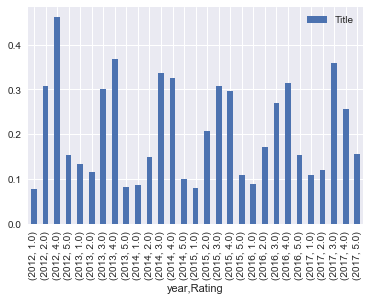

In [48]:
glassdoor_1 = glassdoor.set_index('Review Date')
glassdoor_1['year'] = glassdoor_1.index.year
counts = glassdoor_1.groupby(['year', 'Rating']).agg(len)
counts = pd.DataFrame(counts, columns=['Title'])
counts = counts.groupby(level=[0]).apply(lambda x: x / x.sum())

%matplotlib inline

counts[1:].plot(kind='bar')

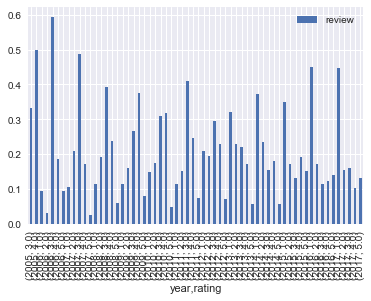

In [94]:
yelp_1 = yelp.set_index('date')
yelp_1['year'] = yelp_1.index.year
counts = yelp_1.groupby(['year', 'rating']).agg(len)
counts = pd.DataFrame(counts, columns=['review'])
counts = counts.groupby(level=[0]).apply(lambda x: x / x.sum())

%matplotlib inline

counts.plot(kind='bar')

In [95]:
counts

review
year rating          
2005 2.0     0.166667
     3.0     0.333333
     4.0     0.500000
2006 1.0     0.093750
     2.0     0.031250
     3.0     0.593750
     4.0     0.187500
     5.0     0.093750
2007 1.0     0.105263
     2.0     0.210526
     3.0     0.486842
     4.0     0.171053
     5.0     0.026316
2008 1.0     0.115385
     2.0     0.192308
     3.0     0.392308
     4.0     0.238462
     5.0     0.061538
2009 1.0     0.116071
     2.0     0.160714
     3.0     0.267857
     4.0     0.375000
     5.0     0.080357
2010 1.0     0.147887
     2.0     0.176056
     3.0     0.309859
     4.0     0.316901
     5.0     0.049296
2011 1.0     0.113924
     2.0     0.151899
     3.0     0.411392
     4.0     0.246835
     5.0     0.075949
2012 1.0     0.208633
     2.0     0.194245
     3.0     0.294964
     4.0     0.230216
     5.0     0.071942
2013 1.0     0.321429
     2.0     0.228571
     3.0     0.221429
     4.0     0.171429
     5.0     0.057143
2014 1.0     0.372642
     2.0     0.235849
     3.0     0.155660
     4.0     0.179245
     5.0     0.056604
2015 1.0     0.350254
     2.0     0.172589
     3.0     0.131980
     4.0     0.192893
     5.0     0.152284
2016 1.0     0.451477
     2.0     0.172996
     3.0     0.113924
     4.0     0.122363
     5.0     0.139241
2017 1.0     0.448529
     2.0     0.154412
     3.0     0.161765
     4.0     0.102941
     5.0     0.132353

In [101]:
count_5 = counts[counts.index(level=1)==5]

TypeError: 'MultiIndex' object is not callable

In [107]:
str_count = counts["review"]

In [109]:
str_count

year  rating
2005  2.0       0.166667
      3.0       0.333333
      4.0       0.500000
2006  1.0       0.093750
      2.0       0.031250
      3.0       0.593750
      4.0       0.187500
      5.0       0.093750
2007  1.0       0.105263
      2.0       0.210526
      3.0       0.486842
      4.0       0.171053
      5.0       0.026316
2008  1.0       0.115385
      2.0       0.192308
      3.0       0.392308
      4.0       0.238462
      5.0       0.061538
2009  1.0       0.116071
      2.0       0.160714
      3.0       0.267857
      4.0       0.375000
      5.0       0.080357
2010  1.0       0.147887
      2.0       0.176056
      3.0       0.309859
      4.0       0.316901
      5.0       0.049296
2011  1.0       0.113924
      2.0       0.151899
      3.0       0.411392
      4.0       0.246835
      5.0       0.075949
2012  1.0       0.208633
      2.0       0.194245
      3.0       0.294964
      4.0       0.230216
      5.0       0.071942
2013  1.0       0.321429
      2.0   

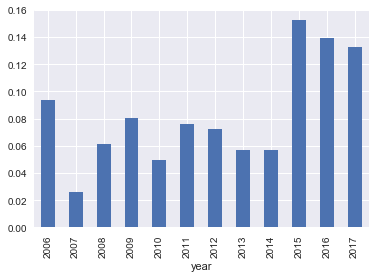

In [112]:
str_count_5 = str_count.loc[slice(None), 5.0]

str_count_5.plot(kind='bar')

In [ ]:
Now Just Going to try the averaging method:
    

In [123]:
# This is a good stat as it shows you the friend count of hte people that rated your company
# As good, I can see how you would be able to put a lot of emphasis on a report like this. 


yelp_1 = yelp.set_index('date')
yelp_1['year'] = yelp_1.index.year
avg_yp = yelp_1.groupby(['year', 'rating']).mean()
#avg = pd.DataFrame(avg, columns=['review'])

In [124]:
avg_yp = yelp_1.groupby(['year']).mean()

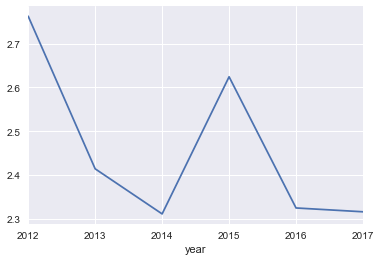

In [156]:
avg_yp['rating'].ix[min(avg_gd[1:].index):].plot(kind='line')

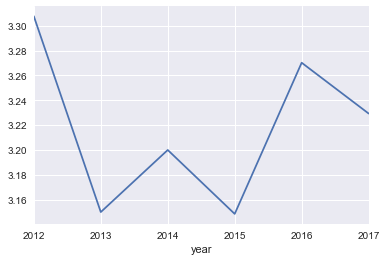

In [154]:
glassdoor_1 = glassdoor.set_index('Review Date')
glassdoor_1['year'] = glassdoor_1.index.year
avg_gd = glassdoor_1.groupby(['year']).mean()
avg_gd["Rating"][1:].plot(kind='line')

In [158]:
fund = pd.read_csv("fundamental.csv")

fund['datadate'] = fund['datadate'].apply(lambda x: parse(str(x)))

In [159]:
fund.tail()

,GVKEY,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,adrrq,curcdq,datacqtr,datafqtr,ceiexbillq,cogsq,epspi12,nopiq,reunaq,spcep12,spceq,utemq,xoprq,xsgaq,costat,mkvaltq,prccq,spcsrc
43,63739,2015-12-31,2015,4,INDL,C,D,STD,NaN,USD,2015Q4,2015Q4,NaN,186.632,1.76,-1.359,245.826,NaN,NaN,NaN,200.621,13.989,A,1072.4918,43.47,B+
44,63739,2016-03-31,2016,1,INDL,C,D,STD,NaN,USD,2016Q1,2016Q1,NaN,194.491,1.87,-0.312,242.098,NaN,NaN,NaN,210.292,15.801,A,1002.8347,41.57,B+
45,63739,2016-06-30,2016,2,INDL,C,D,STD,NaN,USD,2016Q2,2016Q2,NaN,198.694,1.96,-0.619,257.140,NaN,NaN,NaN,214.020,15.326,A,1059.1520,43.83,B+
46,63739,2016-09-30,2016,3,INDL,C,D,STD,NaN,USD,2016Q3,2016Q3,NaN,192.390,1.78,-0.322,242.812,NaN,NaN,NaN,207.529,15.139,A,839.6199,35.55,B+
47,63739,2016-12-31,2016,4,INDL,C,D,STD,NaN,USD,2016Q4,2016Q4,NaN,215.838,1.91,-0.338,208.697,NaN,NaN,NaN,231.922,16.084,A,877.6476,39.30,B+


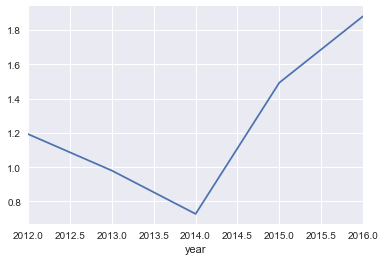

In [160]:
from datetime import datetime
from dateutil.parser import parse


fund = fund.set_index('datadate')
fund['year'] = fund.index.year
avg_f = fund.groupby(['year']).mean()
avg_f["epspi12"].ix[min(avg_gd[1:].index):].plot(kind='line')


In [130]:
avg_yp["rating"]

year
2005    3.333333
2006    3.156250
2007    2.802632
2008    2.938462
2009    3.142857
2010    2.943662
2011    3.018987
2012    2.762590
2013    2.414286
2014    2.311321
2015    2.624365
2016    2.324895
2017    2.316176
Name: rating, dtype: float64

In [134]:
min(avg_gd.index)

2010

In [155]:
avg_yp['rating'].ix[min(avg_gd[1:].index):].corr(avg_gd["Rating"])


0.20890211010089538

In [7]:
yelp = pd.read_csv("bjs-restaurant-sanbruno.csv")

In [8]:
yelp["date"] = yelp["date"].apply(lambda x: x[:10])
yelp["date"] = yelp["date"].apply(lambda x: x[:-1] if x[-1]=="\\" else x )
yelp["date"] = yelp["date"].apply(lambda x: x[:-2] if x[-1]=="n" else x )

In [9]:
from datetime import datetime
from dateutil.parser import parse

yelp['date'] = yelp['date'].apply(lambda x: parse(x))

In [10]:
yelp.head()

,Username,location,friend_count,review_count,photo_count,date,rating,review
0,Finau F.,Millbrae CA,152,38,50.0,2017-09-15,3.0,This is definitely a place you can resort to i...
1,Tanya F.,Fairfield CA,82,20,33.0,2017-09-10,1.0,Seriously the worst restaurant ever:Slow servi...
2,Michelle S.,San Francisco CA,200,143,453.0,2017-09-09,2.0,Yikes.So the venue itself is cool. Nice decor ...
3,Danielle S.,Pacifica CA,246,33,50.0,2017-08-31,4.0,Did you know that BJ's has a ton of promotions...
4,Teena N.,San Francisco CA,35,235,1076.0,2017-08-26,3.0,Second time here first time dining in. +Spina...


In [11]:
import itertools as it
import spacy

nlp = spacy.load('en')


In [12]:
sample_review = yelp["review"][0]

print(sample_review)

%%time
parsed_review = nlp(sample_review)

print(parsed_review)

In [16]:
for num, sentence in enumerate(parsed_review.sents):
    print('Sentence {}:'.format(num + 1))
    print(sentence)
    print("")

Sentence 1:
This is definitely a place you can resort to if court food doesn't cut it for you in the mall!

Sentence 2:
Personally after trying a handful of entrees I only seem to get the two same things each time I come here Parmesan Chicken and the infamous cookies n' cream Pizookie!

Sentence 3:
There's always a long wait but it's nice there's a Barnes&Noble and different shops near to roam around until they text you with your table ready!

Sentence 4:
Customer service could be improved but in such a busy chaotic place that's obviously asking to much of these young waiters/waitresses.



In [18]:
for num, entity in enumerate(parsed_review.ents):
    print('Entity {}:'.format(num + 1), entity, '-', entity.label_)
    print("")

Entity 1: two - CARDINAL

Entity 2: Parmesan Chicken - ORG

Entity 3: Pizookie - PERSON



In [26]:
np.array(zip(token_text, token_pos))

array(<zip object at 0x11d909b88>, dtype=object)

In [34]:
token_text = [token.orth_ for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]

df = pd.DataFrame({'token_text':token_text, 'part_of_speech':token_pos})

In [43]:
df

,part_of_speech,token_text
0,DET,This
1,VERB,is
2,ADV,definitely
3,DET,a
4,NOUN,place
5,PRON,you
6,VERB,can
7,VERB,resort
8,ADP,to
9,ADP,if


In [46]:
# Zip is different for Python 3 It is an itterator in three so have to be dealt with.

token_lemma = [token.lemma_ for token in parsed_review]
token_shape = [token.shape_ for token in parsed_review]

pd.DataFrame(list(zip(token_text, token_lemma, token_shape))[:],
             columns=['token_text', 'token_lemma', 'token_shape'])

,token_text,token_lemma,token_shape
0,This,this,Xxxx
1,is,be,xx
2,definitely,definitely,xxxx
3,a,a,x
4,place,place,xxxx
5,you,-PRON-,xxx
6,can,can,xxx
7,resort,resort,xxxx
8,to,to,xx
9,if,if,xx


In [49]:
token_entity_type = [token.ent_type_ for token in parsed_review]
token_entity_iob = [token.ent_iob_ for token in parsed_review]

pd.DataFrame(list(zip(token_text, token_entity_type, token_entity_iob))[:],
             columns=['token_text', 'entity_type', 'inside_outside_begin'])

,token_text,entity_type,inside_outside_begin
0,This,,O
1,is,,O
2,definitely,,O
3,a,,O
4,place,,O
5,you,,O
6,can,,O
7,resort,,O
8,to,,O
9,if,,O


In [50]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in parsed_review]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
df

,text,log_probability,stop?,punctuation?,whitespace?,number?,out of vocab.?
0,This,-6.785319,Yes,,,,
1,is,-4.329765,Yes,,,,
2,definitely,-9.063265,,,,,
3,a,-3.983075,Yes,,,,
4,place,-8.045827,,,,,
5,you,-4.547973,Yes,,,,
6,can,-5.913871,Yes,,,,
7,resort,-11.149202,,,,,
8,to,-3.838520,Yes,,,,
9,if,-5.885849,Yes,,,,


In [52]:
# This part of the analysis is different to the on that I am used to. 

from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

In [53]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [85]:
# Writing all the reviews to a file, each item in the list to a new line
# Import os

thefile = open('test.txt', 'w')

for item in yelp["review"].tolist():
  thefile.write("%s\n" % item)


In [86]:
#intermediate_directory = os.path.join('..', 'intermediate')

unigram_sentences_filepath = os.path.join('uni_test.txt')



In [87]:
%%time

import os
import codecs


# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 0:

    with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus("test.txt"):
            f.write(sentence + '\n')

CPU times: user 14.7 s, sys: 1.59 s, total: 16.3 s
Wall time: 16.6 s


In [88]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [89]:
for unigram_sentence in it.islice(unigram_sentences, 10, 20):
    print(u' '.join(unigram_sentence))
    print(u'')
    # Once you have a few more companies the above, bi,tri rams will go down well.

but again yike

food come out super slow

-PRON- take so long -PRON- almost ask and -PRON- never ask

the server also put -PRON- appetizer in as entree so -PRON- apps come out at the same time as -PRON- entree which be pretty frustrating

also two of -PRON- dish be straight up cold

like not kinda cold like cold

like -PRON- sweet potato fry feel like -PRON- would be sit out for 30 minute

-PRON- send -PRON- back and the server do not seem surprised or apologetic

seem kind of like the norm

the sweet potato fry be good -PRON- fried calamari be okay



In [92]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings
import cPickle as pickle

ModuleNotFoundError: No module named 'pyLDAvis'